In [1]:
import kwant
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import tinyarray # Fast and memory saving matrix support 
import sympy

#  creating Hamiltonian

We want to look at a 3D nanowire grown along x direction. We know the low energy effective model, consisting of a 4x4 Dirac Hamiltonian (2 spin degrees of freedom and 2 orbital degrees of freedom). We want to add magnetic field oriented along x direction via peierls substitution. The Model without magnetic field respects time reversal symmetry. We set ALL constants = 1 for simplicity.  (if your are interested in some more details aobut the hamiltonian see the supplemental material of  https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.176404)

Discretization:

The Dirac Hamiltonian has the form $ \tau_0 \sigma_0 + k_x \tau_x \sigma_z +  k_y \tau_y \sigma_0 + k_z \tau_x \sigma_x$. We interpret $k_x$, $k_y$ and $k_z$ as differential operators (e.g. $k_x = -i \partial_x$), which yields hopping terms in our discritized Hamiltonian as we will see.


Our discretized model is e.g. a square lattice with lattice parameter a, then we can write the positional ket as |x,y, z> = |i a, j a, l a> =: |i,j, l >   (<i', j', l'|i,j, l> = $\delta_{ii'} \delta_{jj'} \delta_{ll'}$)
For discretization we use the symmetric definition (for small enough a):
$\partial_x f(x) \approx \frac{1}{2a} (f(x+a)- f(x-a)) = \frac{1}{2a} \sum_{i'j'l'} f_{i'j'l'} (|i'+1, j', l'> - |i'-1,j', l'>)$ (for the first summand the i' goes from 0 to N-1, for the second from 1 to N)

Because we can write f(x) = $\sum_{ijl} f_{ij} |i,j,l>$ (i,j,l from 0 tot N). We can now check which form $\partial_x$ has to be (chaning summation index for the second summand):
$-\mathrm{i} \partial_x = \frac{1}{2a} \sum_{ij} -\mathrm{i} |i+1, j,l><i,j,l| + \mathrm{i} |i,j,l><i+1, j,l| = \frac{1}{2a} \sum_{ijl} (-\mathrm{i} |i+1, j,l><i,j,l| + h.c.)$. (i goes from 0 , to N-1)

Following this discretization scheme we can easily write the Chen15 Hamiltonian in lattice form:
$H = \tau_0 \sigma_0 \sum_{ijl}(  |i, j, l><i,j, l|)   + \frac{1}{2a}  \tau_x \sigma_z \sum_{ijl} (-\mathrm{i} |i+1, j, l><i,j, l| + h.c.)    + \frac{1}{2a}  \tau_y \sigma_0 \sum_{ijl} (-\mathrm{i} |i, j+1, l><i,j, l| + h.c.) + \frac{1}{2a} \tau_x \sigma_x  \sum_{ijl} (-\mathrm{i} |i, j, l+1><i,j, l| + h.c.) $

setting a = 1 in the following and adding peierls substitution

 PS: I know I have to correct for fermion doubling and might could treat $k_x$ as scalar because we have translational symmetry in x direction, but I want to further include disorder and other things. 

In [2]:
#using tinyarray instead of numpy because calculations are faster and less memory intense
tauz_sigma0 = tinyarray.array([[1+0j, 0+0j, 0+0j, 0+0j], [0+0j, 1+0j, 0+0j, 0+0j],
                               [0+0j, 0+0j,-1+0j, 0+0j], [0+0j, 0+0j, 0+0j,-1+0j]])


taux_sigmaz = tinyarray.array([[0+0j, 0+0j, 1+0j, 0+0j], [0+0j, 0+0j, 0+0j,-1+0j],
                              [1+0j, 0+0j, 0+0j, 0+0j], [0+0j,-1+0j, 0+0j,0+0j]])

tauy_sigma0 = tinyarray.array([[0+0j, 0+0j, 0-1j, 0+0j], [0+0j, 0+0j, 0+0j, 0-1j],
                               [0+1j, 0+0j, 0+0j, 0+0j], [0+0j, 0+1j, 0+0j,0+0j]])

taux_sigmax = tinyarray.array([[0+0j, 0+0j, 0+0j, 1+0j], [0+0j, 0+0j, 1+0j, 0+0j],
                               [0+0j, 1+0j, 0+0j, 0+0j], [1+0j, 0+0j, 0+0j, 0+0j]])

tau0_sigmaz = tinyarray.array([[1+0j, 0+0j, 0+0j, 0+0j], [0+0j,-1+0j, 0+0j, 0+0j],
                               [0+0j, 0+0j, 1+0j, 0+0j], [0+0j, 0+0j, 0+0j,-1+0j]])

tau0_sigmax = tinyarray.array([[0+0j, 1+0j, 0+0j, 0+0j], [1+0j, 0+0j, 0+0j, 0+0j],
                               [0+0j, 0+0j, 0+0j, 1+0j], [0+0j, 0+0j, 1+0j,0+0j]])

tau0_sigma0 = tinyarray.array([[1+0j, 0+0j, 0+0j, 0+0j], [0+0j, 1+0j, 0+0j, 0+0j],
                               [0+0j, 0+0j, 1+0j, 0+0j], [0+0j, 0+0j, 0+0j, 1+0j]])


In [3]:
### creating the Nanowire with leads ###

def Chen15_discretized(L, W, H, p, system_type):
    """A cuboid region of ZrTe5 material with two leads attached along x direction.

    parameters for leads and scattering region can be defined separately
    """
    def onsite(site, p):
        return tau0_sigma0     
        
    def hopx(site1, site2, p):
        return -1j* taux_sigmaz 

    def hopy(site1, site2, p):
        return -1j *tauy_sigma0  

    def hopz(site1, site2, p):
        return  -1j*taux_sigmax
    
    def hopz_phase(site1, site2, p):
        x, y, z = site1.pos
        return hopz(site1, site2, p) * np.exp(-1j * p["Bx"] * y) # Bx magnetic field strength
    
    
    def shape_lead(pos):
        (x, y, z) = pos
        return (0 <= z < H) and (0 <= y < W)

    def shape_syst(pos):
        (x, y, z) = pos
        return (0 <= z < H) and (0 <= y < W) and (0 <= x < L)
     
        
    # for each lattice point we have 2 spin and 2 orbital DOF (2*2=4) therefore norbs=4 
    lat = kwant.lattice.general(np.identity(3), norbs=4) 
                                        
    if system_type == "sys":
        syst = kwant.Builder()
        syst[lat.shape(shape_syst, (0, 0, 0))] = lambda site, p: onsite(site, p)
    elif system_type == "lead":
        sym = kwant.TranslationalSymmetry((1, 0, 0))
        syst = kwant.Builder(sym)
        syst[lat.shape(shape_lead, (0, 0, 0))] = lambda site, p: onsite(site, p)

    syst[kwant.HoppingKind((1, 0, 0), lat)] = hopx
    syst[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    syst[kwant.HoppingKind((0, 0, 1), lat)] = hopz_phase
    return syst

def sytem_and_lead(L, W, H,p ):
    # creating the 3d bulk system and attaching 2 leads to it composed of same material
    syst = Chen15_discretized(L, W, H,p, "sys")
    lead = Chen15_discretized(L, W, H,p, "lead")
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    return syst

# current density through x=const plane  METHOD 1

In [4]:
def make_2D_slice(fsyst, x_cut):
        Sites=list(fsyst.sites) 

        # building the 2d cut lattice on which to project the current
        lat_slice=kwant.lattice.square(norbs=4)
        syst_slice=kwant.Builder()  
        # the actual values of onsite are not important. Just important to create onsites
        # which have similar structure as our 3d system. 
        # By omiting the hoppings we just create points of our lattices at positions where we are also
        # interested in the x component of the current density. (the y and z components are not important for us,
        # thus we create no hoppings in y and z direction)
        # The actual value of onsite is not important we use just plane identity matrices with dim=norbs.
        syst_slice[(lat_slice(site.pos[1],site.pos[2]) for site in Sites if site.pos[0]==x_cut)]= tau0_sigma0  # creates onsite term
        fsyst_slice=syst_slice.finalized()
        return(fsyst_slice)

def Plot_current_density_through_xcut(fsyst,para_dic,energy,  x_cut): 
    
    wave_function=kwant.wave_function(fsyst,energy=energy, params=dict(p=para_dic))
    
    def cut(site0,site1):    
        ####################################################################################################
        # QUESTION: if I define site0.pos[0]==x_cut+1  and site1.pos[0]==x_cut then all current densities seem 
        #to become negative, but I want the actual current density profile
        ######################################################################################################
        return site0.pos[0]==x_cut  and site1.pos[0]==x_cut+1  # calculating current just for this x hopping 
    

    # current density just gets calculated along hopping specified by cut
    J_operator = kwant.operator.Current(fsyst, where=cut)
    # total current over all hoppings specified by cut 
    J_total_operator = kwant.operator.Current(fsyst, where=cut, sum=True)
    
    ### caclulating the current density and total current in / through the x=x_cut plane 
    ### by adding contributions from all modes
    psi=wave_function(0)[0] # scattering state from lead (0) incoming in mode [0]
    current_density = J_operator(psi, params=dict(p=para_dic)) 
    current_total = J_total_operator(psi, params=dict(p=para_dic))
    if len(wave_function(0)) > 1:
        for n in range(1, len(wave_function(0))):
            psi = wave_function(0)[n]
            current_density=current_density + J_operator(psi, params=dict(p=para_dic)) 
            current_total = current_total +  J_total_operator(psi, params=dict(p=para_dic))
    
    print(r"The total current through plane x =", x_cut, r"is J =", current_total, r"some unit")
    
    fsyst_slice =  make_2D_slice(fsyst, x_cut)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    kwant.plotter.map(fsyst_slice, current_density, ax=ax, cmap="coolwarm") 
    # color bar with range vmin to vmax is created 
    norm = matplotlib.colors.Normalize(vmin=min(current_density), vmax=max(current_density), clip=False)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap="coolwarm"), label=r"current density in some units")
        
    ax.set_xlabel(r'y site index')
    ax.set_ylabel(r'z site index')
    ax.set_title(r'x current density through plane with x = %1.0f ' % x_cut)
    plt.show()
           
    

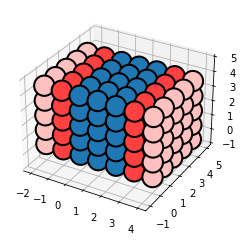

The total current through plane x = 1 is J = 20.000000000000043 some unit


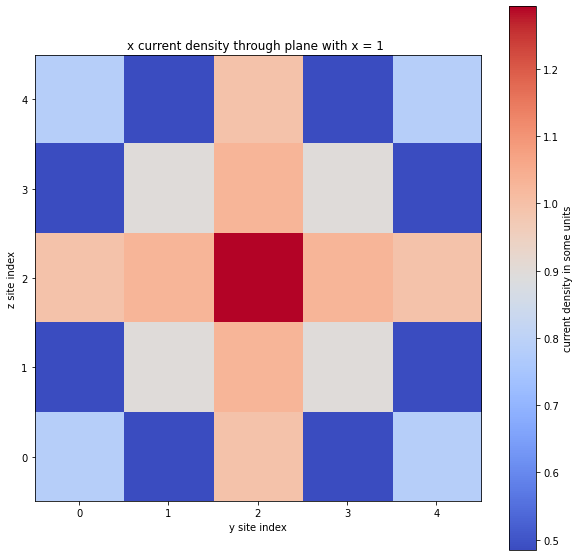

In [5]:
def main10():
    ### PARAMETERS ###  
    L, W, H = 3, 5, 5 # number of x,y and z sites,20 7 7 takes 20 min 10 10 10 takes 23 min to execute 
    para_dic = dict( Bx=1) # Bx magnetic field strength
    
    energy = 1.2 # energy of incoming plane wave for which current density projection in x direction is computed
    
    ### creating of 3d system ###
    syst = sytem_and_lead(L, W, H, para_dic)
    kwant.plot(syst)
    fsyst=syst.finalized()
            
    # plot current density in x direction through hopping from x_cut =1 to x_cut=1+1=2
    Plot_current_density_through_xcut(fsyst,para_dic,energy, x_cut=1)

main10()

# current density through plane x = const METHOD 2


In [6]:
def Plot_current_density_through_xcut11(fsyst,para_dic,energy,  x_cut): 
    
    wave_function=kwant.wave_function(fsyst,energy=energy, params=dict(p=para_dic))
   
    # current density operator for all hoppings
    J_operator = kwant.operator.Current(fsyst)
    # total current operator for all hoppings
    J_total_operator = kwant.operator.Current(fsyst, sum=True)
    
    ### caclulating the current density and total current over all hoppings
    ### by adding contributions from all modes
    psi=wave_function(0)[0] # scattering state from lead (0) incoming in mode [0]
    current_density = J_operator(psi, params=dict(p=para_dic)) 
    current_total = J_total_operator(psi, params=dict(p=para_dic))
    if len(wave_function(0)) > 1:
        for n in range(1, len(wave_function(0))):
            psi = wave_function(0)[n]
            current_density=current_density + J_operator(psi, params=dict(p=para_dic)) 
            current_total = current_total +  J_total_operator(psi, params=dict(p=para_dic))

    # interpolate current density over the system
    field, box = kwant.plotter.interpolate_current(fsyst, current_density)
    
    Y = np.linspace(*box[1], num=field.shape[1])
    Z = np.linspace(*box[2], num=field.shape[2])
    
    # calculating the current density at points y,z in the interpolated current array # not efficient but works
    ny = 0
    nz = 0
    y_vals = []
    z_vals = []
    values = []
    for y in Y:
        for z in Z:
            y_vals.append(ny)
            z_vals.append(nz)
            values.append(field[x_cut,ny,nz,2])
            nz += 1
        nz = 0
        ny += 1

    plt.scatter(y_vals,z_vals,c=values,cmap='magma')
    plt.colorbar()
    plt.show()

/home/felix/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



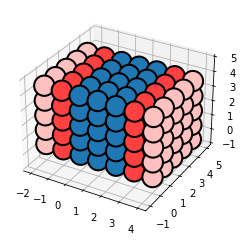

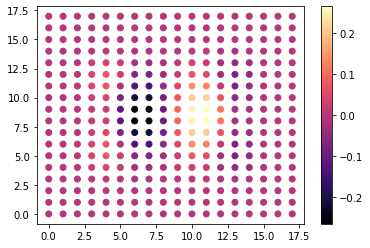

In [7]:
def main11():
    ### PARAMETERS ###  
    L, W, H = 3, 5, 5 # number of x,y and z sites 
    para_dic = dict( Bx=1) # Bx magnetic field strength 
    
    # mind that these parameters just shift the energy spectrum uo (if>0) or down
    # (if<0). Keeping all e.g. zero is a convenient choice without any additional gates considered. (zero bias,
    # zero gate voltage regime )
    
    energy = 1.2 # energy in meV of incoming plane wave for which current density projection in x direction is computed
    
    ### creating of 3d system ###
    
    syst = sytem_and_lead(L, W, H, para_dic)
    kwant.plot(syst)
    fsyst=syst.finalized()

    Plot_current_density_through_xcut11(fsyst,para_dic,energy, x_cut=1)

main11()